In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable as var
from torch.nn import functional as F
import torchtext.vocab as vocab
from tqdm import tqdm
from pprint import pprint
import json
import _pickle as pkl

In [2]:
glove = vocab.GloVe(name='6B', dim=50)

In [3]:
def clean(token):
    cleaned_token = token.strip(".,?!-:;'()[]\"`")
    if cleaned_token[-2:] == "'s":
        cleaned_token = cleaned_token[:-2]
    if cleaned_token[-2:] == "'t":
        cleaned_token = cleaned_token[:-2]+'t'
    return cleaned_token

def get_vector(word):
    return glove.vectors[glove.stoi[word]]

def vectorize(input_txt, only_idx=False):
    input_seq = [clean(w) for w in input_txt if len(clean(w).strip())][:200]
    if only_idx:
        glove_vec = [glove.stoi[w] for w in input_seq]
        return torch.LongTensor(glove_vec)
    else:
        glove_vec = [get_vector(w).tolist() for w in input_seq]
        return torch.FloatTensor(glove_vec)

In [4]:
with open('../data/data.json', 'r') as f:
    data = json.load(f)

In [7]:
idx = 4
example_X = (data['X_train'][idx])
example_y = (data['y_train'][idx])
print("Context:", example_X[0])
print("Question:", example_X[1])
print("Answer Span:", example_y)
print("Answer:", example_X[0][example_y[0]:example_y[1]])
X = vectorize(example_X[0].lower())

Context: The staple products of Samoa are copra (dried coconut meat), cocoa bean (for chocolate), and bananas. The annual production of both bananas and copra has been in the range of 13,000 to 15,000 metric tons (about 14,500 to 16,500 short tons). If the rhinoceros beetle in Samoa were eradicated, Samoa could produce in excess of 40,000 metric tons (44,000 short tons) of copra. Samoan cocoa beans are of very high quality and used in fine New Zealand chocolates. Most are Criollo-Forastero hybrids. Coffee grows well, but production has been uneven. WSTEC is the biggest coffee producer. Rubber has been produced in Samoa for many years, but its export value has little impact on the economy.[citation needed]
Question: What pest is the greatest threat to Samoan crops?
Answer Span: [248, 265]
Answer: rhinoceros beetle


In [8]:
def make_data(raw_X):
    X = []
    for (c, q, _) in raw_X:
        context_rep = vectorize(c.lower(), only_idx=True)
        ques_rep = vectorize(q.lower(), only_idx=True)
        X.append(context_rep) #only context for now
    return X
X_pass = make_data(data['X_train'][:20])
y_pass = data['y_train'][:20]

In [9]:
class ModelV1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_size, n_layers=1, opt='adam', lr=1e-3, epochs=5, emb_dim=50):
        super(ModelV1, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        
        if opt == 'adam':
            self.opt = optim.Adam
        else:
            self.opt = optim.SGD
        self.lr = lr
        self.epochs = epochs
        self.emb_dim = emb_dim
        
        self.encoder = nn.Embedding(len(glove.vectors), self.emb_dim)
        self.lstm = nn.LSTM(self.emb_dim, self.hidden_size, self.n_layers)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        self.init_weights()
    
    def init_weights(self):
        weight_scale = 0.01
        self.encoder.weight.data = glove.vectors
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-weight_scale, weight_scale)
    
    def init_hidden(self, batch_size=1):
        weight = next(self.parameters()).data
        return var(weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_())
        
    def forward(self, inputs, hidden):
        inputs = inputs[0]
        embeds = self.encoder(var(inputs)) # get glove repr
        
        lstm_op, (hnext, cnext) = self.lstm(embeds, hidden)
        last = lstm_op[-1]
        out = self.decoder(last)
        return out, (hnext, cnext)

    def fit(self, X, y):
        opt = self.opt(self.parameters(), self.lr)
        losses = []
        for epoch in tqdm(range(5)):
            bs = 1
            tloss = 0.0
            for i in range(0, len(y)-bs+1, bs):
                h, c = self.init_hidden(), self.init_hidden()
                opt.zero_grad()
                Xb = X[i:i+bs]
                yb = var(torch.FloatTensor(y[i:i+bs]))
                pred, (h, c) = self.forward(Xb, (h, c)) #prediction on batch features
                loss = F.mse_loss(pred, yb)
                tloss += loss.data[0]
                loss.backward()
                opt.step()
            losses.append(tloss)
        self.hidden = (h, c)
        return losses

    def predict(self, X):
        return self.forward(X, self.hidden)[0]

In [10]:
model = ModelV1(200, 100, 2, batch_size=1, epochs=2)

In [11]:
res = model.fit(X_pass, y_pass)

100%|██████████| 5/5 [00:55<00:00, 11.14s/it]


In [14]:
model.predict([X_pass[2]])

Variable containing:
 9.2979  9.5208
[torch.FloatTensor of size 1x2]

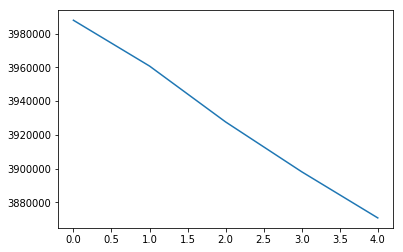

In [15]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(res))), res)
plt.show()